## Consumer Food Demand Estimation

Team members: Stone Yan, Angela Chen, Yingyin Li, Tia Pappas, Daniela Salinas, Lyuheng(Kasper) Zheng

#### Our Topic and Population of Interest:

We are interested in the population of Panama. Our topic is about understanding diets in Panama, characterizing the relationship between people’s food choices, budget and prices. 

#### Our Goals:  

1. Analyze Panama households' food choices and expenditures to assess their diets' nutritional content and adequacy.
<br>
2. Estimate food demand among Panama, considering household needs and economic factors, and to analyze how changes in expenditure and food prices influence dietary choices.
<br>
3. Conduct counterfactual experiments to assess how hypothetical economic scenarios, such as changes in food expenditure, prices, shortages, and income, could affect Panama's nutrition.


### (A) Choice of Population & Supporting Data

#### Data Frame Set Up

In the following we will be estimating Constant Frisch Elasticity (CFE) demand systems for our selected population - Panama. We first installed our prerequisites. 

In [1]:
!pip install -r requirements.txt 
!pip install CFEDemands --upgrade --pre -q
!pip install eep153_tools --upgrade -q

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
linearmodels 0.0.0 requires setuptools-scm[toml]<9.0.0,>=8.0.0, which is not installed.
fenics-dolfin 2019.1.0 requires pybind11==2.2.4, but you have pybind11 2.9.2 which is incompatible.


In the following we will be estimating Constant Frisch Elasticity (CFE) demand systems for our selected population - Panama. We first imported the data we need from the Google Sheet. 

In [4]:
InputFiles = {'Food Expenditures':('1gcAb2jlGQNrD2zrrTEbjL47vbXoxCHkkjHSYzD0-Tiw','Food Expenditures'),
              'Food Prices':('1gcAb2jlGQNrD2zrrTEbjL47vbXoxCHkkjHSYzD0-Tiw','Food Prices'),
              'Household Characteristics':('1gcAb2jlGQNrD2zrrTEbjL47vbXoxCHkkjHSYzD0-Tiw','Household Characteristics'),
              'FCT':('1gcAb2jlGQNrD2zrrTEbjL47vbXoxCHkkjHSYzD0-Tiw','FCT'),
              'Copy of RDI':('1gcAb2jlGQNrD2zrrTEbjL47vbXoxCHkkjHSYzD0-Tiw','Copy of RDI'),}

We then imported packages that are needed. 

In [5]:
import numpy as np
import pandas as pd
from eep153_tools.sheets import read_sheets
import cfe
from cfe.estimation import drop_columns_wo_covariance
from cfe import Regression

In [6]:
def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

In [7]:
# Get food expenditures 
expenditures = get_clean_sheet(InputFiles['Food Expenditures'][0],
                    sheet=InputFiles['Food Expenditures'][1])

if 'm' not in expenditures.columns:
    expenditures['m'] = 1

expenditures = expenditures.set_index(['i','t','m'])
expenditures.columns.name = 'j'

expenditures = expenditures.apply(lambda x: pd.to_numeric(x,errors='coerce'))
expenditures = expenditures.replace(0,np.nan)

In [8]:
expenditures = expenditures.loc[~expenditures.index.duplicated()]

In [9]:
# Get Household characteristics 
hh_characteristics = get_clean_sheet(InputFiles['Household Characteristics'][0],
                    sheet=InputFiles['Household Characteristics'][1])

if 'm' not in hh_characteristics.columns:
    hh_characteristics['m'] = 1

hh_characteristics = hh_characteristics.set_index(['i','t','m'])
hh_characteristics.columns.name = 'k'
#hh_characteristics.name = 'value'  

hh_characteristics = hh_characteristics.apply(lambda x: pd.to_numeric(x,errors='coerce'))

In [10]:
hh_characteristics.index.is_unique 

True

In [11]:
# Get food prices and call it p
url = 'https://docs.google.com/spreadsheets/d/1gcAb2jlGQNrD2zrrTEbjL47vbXoxCHkkjHSYzD0-Tiw/edit#gid=2085637103'
p = read_sheets(url,sheet='Food Prices',nheaders=2)

p.columns.names = ['t','m']
p.groupby(level='j').mean()

#use tranpose to switch columns and rows
p = p.transpose()
if 'm' not in p.columns:
    p['m']=1

p=p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p=p.replace(0,np.nan)

In [12]:
# Get FCT
fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

In [13]:
# Get RDI
rdi = get_clean_sheet(InputFiles['Copy of RDI'][0],
                    sheet=InputFiles['Copy of RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

#### Show Organized Data Frame

Show food expenditures dataframe.

In [14]:
expenditures.head()

,,j,Aceite Vegetal,Aguacates,Ahí Verde,Ajo,Alimento Infantil,Apio,Arroz,Arvejas,Azúcar,Café Y Té,...,"Sodas, Refrescos Y Jugos",Sopa Enlatada,Tercer otro,Tomate,Viscera De Res,Visceras De Pollo O Gallina,Yuca,Zanahoria,Zapallo / Chayote,Ñame
i,t,m,,,,,,,,,,,,,,,,,,,,,
19971000,1997,Chíriqui,6.0,NaN,0.5,NaN,2.7,0.3,7.25,NaN,1.6,NaN,...,8.0,0.7,NaN,NaN,NaN,NaN,NaN,0.8,NaN,0.4
19971001,1997,Chíriqui,NaN,NaN,NaN,NaN,NaN,NaN,4.80,NaN,NaN,1.4,...,1.5,NaN,NaN,0.3,NaN,NaN,NaN,NaN,NaN,NaN
19971002,1997,Chíriqui,3.5,NaN,NaN,NaN,NaN,NaN,6.00,NaN,2.0,3.6,...,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
19971003,1997,Chíriqui,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19971005,1997,Chíriqui,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,1.5,...,NaN,0.7,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


Show household characteristics dataframe.

In [15]:
hh_characteristics.head()

,,k,women,boys,men,girls,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
1997125,1997,Herrera,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1.098612
1997160,1997,Herrera,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1.098612
1997170,1997,Bocas Del Toro,1,3,1,4,1,2,1,0,0,1,1,1,0,0,0,1,1,0,2.197225
1997177,1997,Bocas Del Toro,4,9,1,5,2,1,4,1,1,3,2,0,0,2,0,2,1,0,2.944439
1997178,1997,Bocas Del Toro,2,1,2,2,0,0,0,1,1,0,0,1,2,0,0,1,0,1,1.945910


Show food prices dataframe.

In [16]:
p.head()

j                   Aceite Vegetal                                            \
u                       1/2 gallon  None bottle    can gallon gram large bay   
t    m                                                                         
1997 Bocas Del Toro          3.225   NaN   1.20  2.975   6.70  NaN     1.500   
     Chíriqui                3.250  0.10   1.35    NaN   5.95  NaN     1.350   
     Coclé                   2.990  0.10   1.30    NaN   5.90  NaN     1.375   
     Colón                   3.250  0.10   1.34    NaN   5.75  NaN       NaN   
     Darién                  3.200  0.25   1.40    NaN   4.85  NaN     1.525   

j                                                ... Zapallo / Chayote  \
u                   liter medium bar milliliter  ...              unit   
t    m                                           ...                     
1997 Bocas Del Toro   NaN      1.050        NaN  ...              0.10   
     Chíriqui         NaN      1.325        NaN  ...              0.10   
     Coclé            NaN      1.275        NaN  ...              0.15   
     Colón            NaN      0.850        NaN  ...              0.25   
     Darién           NaN      1.400        NaN  ...               NaN   

j                                    Ñame                                 \
u                       value bag or sack gram ounce package pound  unit   
t    m                                                                     
1997 Bocas Del Toro       NaN         3.6  NaN   NaN     NaN  0.40   NaN   
     Chíriqui        0.084416         NaN  NaN   NaN     NaN  0.40  0.15   
     Coclé           0.201299         NaN  NaN   NaN     NaN  0.50  0.50   
     Colón           0.045455         NaN  NaN   NaN     NaN  0.40  0.60   
     Darién               NaN         NaN  NaN   NaN     NaN  0.15   NaN   

j                              m  
u                       value     
t    m                            
1997 Bocas Del Toro       NaN  1  
     Chíriqui        0.038961  1  
     Coclé                NaN  1  
     Colón           0.064935  1  
     Darién               NaN  1  

[5 rows x 691 columns]

Show FCT dataframe.

In [17]:
fct.head()

n,Agua,Energía,Proteina,Grasa Total,Carbo-hidratos,Fibra Diet. total,Ceniza,Calcio,Fosforo,Hierro,...,Colesterol,Potasio,Sodio,Zinc,Magnesio,Vit. B6,Vit. B12,Ac. Fólico,Folato Equiv. FD,Fracción Comestible
j,,,,,,,,,,,,,,,,,,,,,
Aceite Vegetal,0.00,884,0.00,100.00,0.00,0.0,0.00,0,0,0.00,...,0,0,0,0.00,0,0.00,0.0,0,0,1.00
Aguacates,73.23,160,2.00,14.66,8.53,6.7,1.58,12,52,0.55,...,0,485,7,0.64,29,0.26,0.0,0,81,0.74
Ahí Verde,93.89,20,0.86,0.17,3.64,1.7,0.43,10,20,0.34,...,0,175,3,0.13,10,0.22,0.0,0,11,0.82
Ajo,63.80,134,5.30,0.20,29.30,0.0,1.40,38,134,1.40,...,0,529,19,1.00,0,0.00,0.0,3,0,0.94
Alimento Infantil,3.00,510,12.50,27.00,54.30,0.0,3.20,530,420,9.00,...,0,600,180,6.00,55,0.30,1.5,80,136,1.00


Show RDI dataframe.

In [18]:
rdi.head()

k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0


### (A) Estimate demand system

 Let $y_{i}^j$ be log household expenditure on food item $j$ from household $i$ of Panama. Our estimation regression takes the following form: 
 $$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$

The formula above models the log household expenditure as a function of :<br>

$A^j(p)$: A price index for food $j$, capturing how the pricing of good $j$ affects expenditure on food $j$;
<br>
$\gamma_j'd_i$: A household characterics demonstrating how demographics affects expenditure on food $j$; $\gamma_j$ is its coefficient.
<br>
$\beta_j w_i$: This term captures how the household's overall wealth affects its expenditure on food $j$; $\beta_j$ is its coefficent.
<br>
$\zeta^j_i$: This term captures other unobserved effect that influence food expenditure. 


In [19]:
# log_expenditures represents the logarithm of food expenditures.
log_expenditures = np.log(expenditures)

log_expenditures.head()

,,j,Aceite Vegetal,Aguacates,Ahí Verde,Ajo,Alimento Infantil,Apio,Arroz,Arvejas,Azúcar,Café Y Té,...,"Sodas, Refrescos Y Jugos",Sopa Enlatada,Tercer otro,Tomate,Viscera De Res,Visceras De Pollo O Gallina,Yuca,Zanahoria,Zapallo / Chayote,Ñame
i,t,m,,,,,,,,,,,,,,,,,,,,,
19971000,1997,Chíriqui,1.791759,NaN,-0.693147,NaN,0.993252,-1.203973,1.981001,NaN,0.470004,NaN,...,2.079442,-0.356675,NaN,NaN,NaN,NaN,NaN,-0.223144,NaN,-0.916291
19971001,1997,Chíriqui,NaN,NaN,NaN,NaN,NaN,NaN,1.568616,NaN,NaN,0.336472,...,0.405465,NaN,NaN,-1.203973,NaN,NaN,NaN,NaN,NaN,NaN
19971002,1997,Chíriqui,1.252763,NaN,NaN,NaN,NaN,NaN,1.791759,NaN,0.693147,1.280934,...,NaN,1.252763,NaN,NaN,NaN,NaN,NaN,NaN,0.693147,NaN
19971003,1997,Chíriqui,1.252763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19971005,1997,Chíriqui,1.308333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.504077,0.405465,...,NaN,-0.356675,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [20]:
# use is the intersection of indexs between log_expenditures and household characteristics.
use = log_expenditures.index.intersection(hh_characteristics.index)

log_expenditures = log_expenditures.loc[use,:]
hh_characteristics = hh_characteristics.loc[use,:]

In [21]:
log_expenditures = log_expenditures.stack()
hh_characteristics = hh_characteristics.stack()

# Check that indices are in right places!
assert log_expenditures.index.names == ['i','t','m','j']
assert hh_characteristics.index.names == ['i','t','m','k']

#### 1. Basic Estimation Using Regression

In [22]:
#set up regression
result = Regression(y = log_expenditures,d = hh_characteristics)

In [23]:
#get regression results
result.predicted_expenditures()

i         t     m                    j                        
20081     2008  Bocas Del Toro       Aceite Vegetal               5.326744
                                     Ajo                          0.686368
                                     Arroz                        7.549828
                                     Azúcar                       2.972885
                                     Café Y Té                    2.636834
                                                                    ...   
20087040  2008  Comarca Ngobe Bugle  Queso (Blanco Y Amarillo)    1.720973
                                     Raspados Y Duros             1.391364
                                     Sal                          0.630284
                                     Sardina Y Atún               3.746857
                                     Sodas, Refrescos Y Jugos     2.617251
Length: 417378, dtype: float64

<Axes: xlabel='yhat', ylabel='y'>

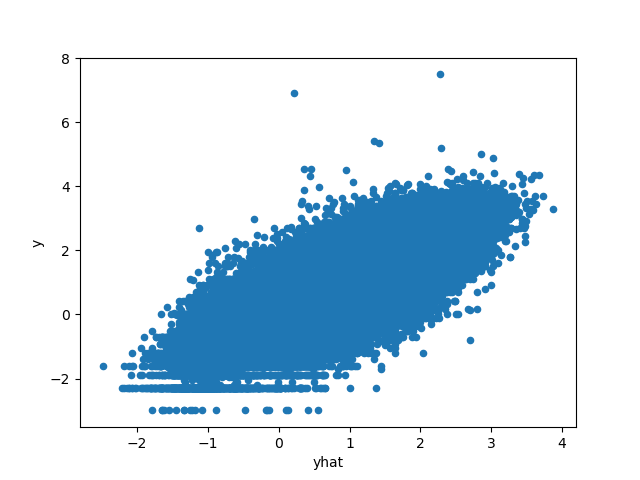

In [24]:
# use the graph to compare log food expenditures and actual expenditures
%matplotlib widget
df = pd.DataFrame({'y':log_expenditures,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

#### 2. Analyze Income Elasticity

In [25]:
#get the value of beta - As shown above, beta captures how the household's overall wealth affects its expenditures on food. 
result.get_beta().sort_values()

j
Arroz                           0.192973
Sal                             0.201887
Porotos                         0.280774
Lentejas                        0.285185
Harina De Trigo                 0.300230
Azúcar                          0.324121
Café Y Té                       0.334031
Ajo                             0.400300
Aceite Vegetal                  0.439102
Huevos De Gallina               0.448744
Sardina Y Atún                  0.465135
Pastas Alimenticias             0.474768
Cebolla                         0.487377
Carnes De Puerco                0.554748
Pastas De Tomate                0.562173
Lecha Evaporada                 0.562755
Pescados                        0.603913
Pollo O Gallina                 0.610001
Queso (Blanco Y Amarillo)       0.681416
Raspados Y Duros                0.712380
Cereales Y Cremas               0.734479
Pan De Sal Y Pan De Dulce       0.746018
Embutidos                       0.766246
Galletas / Pasteles Y Dulces    0.777834
Sodas, Refresc

The beta values above show us how household's overal wealth affect food expenditures. A smaller beta value is associated with a more inelastic product and it is more stable. For example, arroz (rice) is a necessity good for Panama households and gaining more wealth does not heavily influence spending on rice.

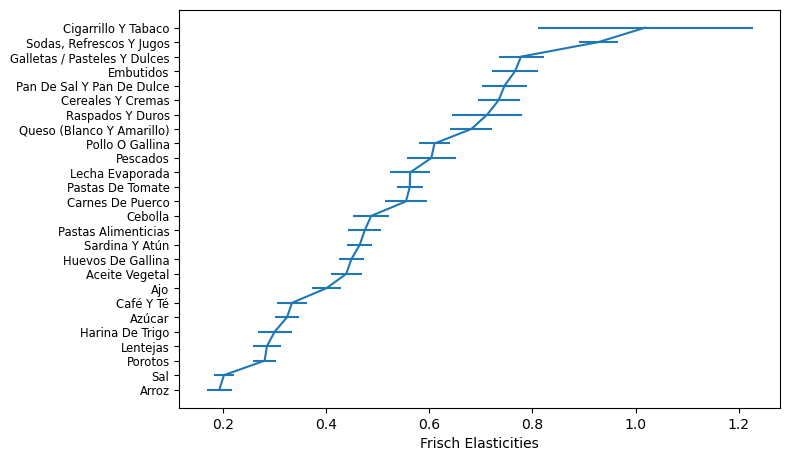

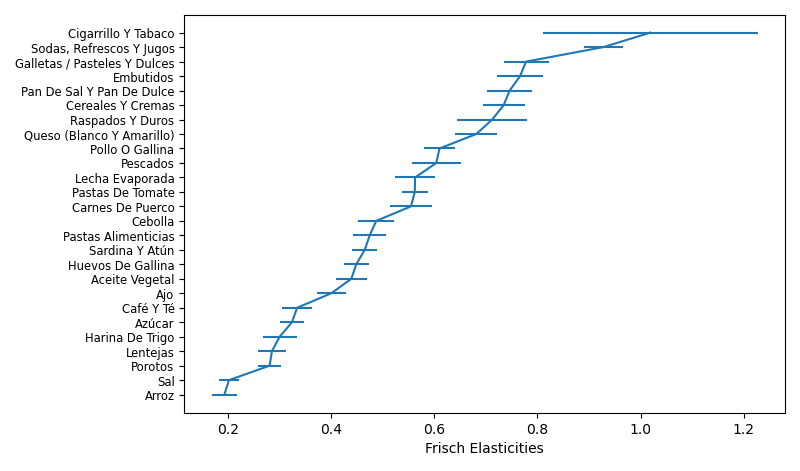

In [26]:
#graph beta
result.graph_beta()

In [27]:
#get the value of gamma - As shown above, gamma captures how household characteristics affects its expenditures on food. 
result.gamma

k,women,boys,men,girls,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,,,,,
Aceite Vegetal,-0.218800,-0.024408,-0.030141,-0.230595,-0.084642,0.109983,-0.038135,0.150058,-0.036179,0.178815,-0.015462,0.170152,0.014687,0.236073,0.043749,0.293211,0.061494,0.230366,0.338633,0.974171
Ajo,0.122637,-0.025084,-0.011583,0.110984,-0.035544,-0.177410,-0.052475,-0.173803,-0.014226,-0.143469,-0.003958,-0.130994,0.000739,-0.109235,0.023851,-0.065176,0.044902,-0.078070,0.190007,-0.701542
Arroz,-0.495017,-0.142311,-0.126351,-0.433308,0.067605,0.343353,0.085655,0.377398,0.155812,0.444869,0.209597,0.427199,0.180513,0.438819,0.214572,0.402831,0.216298,0.430696,0.606707,1.794254
Azúcar,-0.265898,-0.326834,-0.375346,-0.222052,0.360380,0.264523,0.367596,0.262885,0.384716,0.285495,0.431125,0.277118,0.412952,0.273946,0.442871,0.285191,0.513693,0.324265,0.320733,0.412778
Café Y Té,0.107552,0.037827,0.071886,0.093084,-0.055893,-0.090284,-0.026736,-0.094427,-0.004059,-0.087892,-0.021151,-0.067830,-0.015116,-0.079083,0.077907,0.003700,0.154792,0.055753,-0.014526,0.498742
Carnes De Puerco,0.045177,-0.301312,-0.294398,-0.033335,0.249685,-0.047868,0.246697,-0.038958,0.251480,0.014306,0.309919,-0.005435,0.319415,-0.012839,0.376477,0.042634,0.424761,-0.049411,0.216704,1.506556
Cebolla,0.517222,-0.781819,-0.770107,0.515412,0.723260,-0.591330,0.733311,-0.569407,0.740026,-0.541136,0.770595,-0.541348,0.780842,-0.494382,0.827029,-0.464914,0.859738,-0.499388,0.246953,-0.127551
Cereales Y Cremas,0.605760,-0.101034,-0.083822,0.578808,0.011618,-0.702876,0.032771,-0.651868,-0.024667,-0.739802,-0.062239,-0.738672,-0.027777,-0.593578,-0.027540,-0.471550,-0.086985,-0.680897,0.520374,0.604486
Cigarrillo Y Tabaco,-0.101663,0.086289,-0.074436,0.141626,-0.240744,-0.251202,-0.134721,-0.336134,-0.044710,-0.189543,-0.048370,-0.035542,0.159658,0.292745,0.164842,0.411516,0.155957,0.148354,-0.147226,0.929062


The y value tables gives us a glimpse of how different household characteristics affect food expenditures on a certain product. For example, an additional woman in Pananma household is associated with a reduction of 0.22 log expenditures of Panama currency spent on Aceite Vegetal (Vegetable Oil).

In [28]:
# Save result
result.to_pickle('estimates.pickle')

result = cfe.regression.read_pickle('estimates.pickle')

In [29]:
from cfe import regression as rgsn
import numpy as np

# Load a regression model from a pickle file that was named 'estimates.pickle' earlier.
r = rgsn.read_pickle('estimates.pickle')

# Use the loaded model to predict expenditures based on the model's estimates.
xhat = r.predicted_expenditures()

# Implied relative prices
p = np.exp(r.get_Ar())

In [30]:
import matplotlib.pyplot as plt
%matplotlib notebook

use = 'Arroz'  # Put the food item that we want demand curve for here. 
               # 'Arroz' is translated to 'rice' in English. 

# Generates an array of 20 evenly spaced numbers from 0.5 to 2.
scale = np.linspace(.5,2,20)

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

# Reference prices - Calculate the average price for each food item across all observations.
pbar = p.groupby(level='j').mean()

def my_prices(p0,p=pbar,j='Arroz'):
    """
    This changes the food prices of good j while holding other food prices unchanged
    """
    p = p.copy()
    p.loc[j] = p0
    return p

/tmp/ipykernel_71/1033580949.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p.xs('Aceite Vegetal',level='j').groupby('t',axis=1).median()
/tmp/ipykernel_71/1033580949.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_per_lb = p.groupby('t',axis=1).median().xs('pound',level='u')


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

# Demand for Rice for household at median budget
plt.plot([r.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Rice for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Rice for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

In [34]:
# p_raw.u.unique().tolist()

In [35]:
# import fooddatacentral as fdc

# print(p)
# # Convert food quantities to FDC units
# for column in columns:
#     df['FDC Quantity'] = df[[column,'u']].T.apply(lambda x : fdc.units(x[column],x['u']))

# df.dropna(how='any') # Drop food with any missing data

# # To use minimum price observed
# Prices = df.groupby('Food')['FDC Price'].min()

# Prices

### B) Nutritional Content of Different Foods

In [37]:
# The FCT table shows the nutrients of each food item in our dataset. 
fct.head(10)

n,Agua,Energía,Proteina,Grasa Total,Carbo-hidratos,Fibra Diet. total,Ceniza,Calcio,Fosforo,Hierro,...,Colesterol,Potasio,Sodio,Zinc,Magnesio,Vit. B6,Vit. B12,Ac. Fólico,Folato Equiv. FD,Fracción Comestible
j,,,,,,,,,,,,,,,,,,,,,
Aceite Vegetal,0.00,884,0.00,100.00,0.00,0.0,0.00,0,0,0.00,...,0,0,0,0.00,0,0.00,0.0,0,0,1.00
Aguacates,73.23,160,2.00,14.66,8.53,6.7,1.58,12,52,0.55,...,0,485,7,0.64,29,0.26,0.0,0,81,0.74
Ahí Verde,93.89,20,0.86,0.17,3.64,1.7,0.43,10,20,0.34,...,0,175,3,0.13,10,0.22,0.0,0,11,0.82
Ajo,63.80,134,5.30,0.20,29.30,0.0,1.40,38,134,1.40,...,0,529,19,1.00,0,0.00,0.0,3,0,0.94
Alimento Infantil,3.00,510,12.50,27.00,54.30,0.0,3.20,530,420,9.00,...,0,600,180,6.00,55,0.30,1.5,80,136,1.00
Apio,95.43,14,0.69,0.17,2.97,1.6,0.75,40,24,0.20,...,0,260,80,0.13,11,0.07,0.0,0,36,0.89
Arroz,12.37,362,7.50,2.68,76.17,3.4,1.27,33,264,1.80,...,0,268,4,2.02,143,0.51,0.0,0,20,1.00
Arvejas,11.27,341,24.55,1.16,60.37,25.5,2.65,55,366,4.43,...,0,981,15,3.01,115,0.17,0.0,0,274,1.00
Azúcar,0.70,384,0.00,0.00,99.10,0.0,0.20,5,1,0.10,...,0,0,0,0.00,0,0.00,0.0,0,0,1.00


In [38]:
# The following table shows the recommended daily intakes for different populations, across males and females of various ages.
rdi.head(10)

k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
Carbohydrate,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
Iron,7.0,7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
Magnesium,80.0,80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
Niacin,6.0,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0


### C) Counterfactual Experiments

In this section we look at different scenarios.

If everyone's food expenditure doubled (holding prices fixed), how would this affect nutrition in Panama?

In [39]:
# Doubling food expenditures in Panama while holding food prices unchanged. 
double_exp = expenditures * 2
double_exp.head()

double_result = cfe.Regression(y=np.log(double_exp.stack()), d=hh_characteristics)